# MUSHROOMS CLASSIFICATION


## Introduction

The idea of the project is to classify the most common mushroom species in Northen Europe.
This is done using TensorFlow library and Keras, a high level API used to build and train machine learning models, which is capable of running on TensorFlow. 

In [ ]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Download and prepare the dataset



The dataset is divided in two folders: training and test with ratio 0.9 and 0.1.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the dataset

In [ ]:
!unzip /content/drive/Shareddrives/Progetto_CIDL/Dataset_4c_avg.zip -d .

Archive:  /content/drive/Shareddrives/Progetto_CIDL/Dataset_4c_avg.zip
   creating: ./Dataset_4c_avg/test/
   creating: ./Dataset_4c_avg/test/Amanita/
  inflating: ./Dataset_4c_avg/test/Amanita/006_862rFWvLb4I.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/008_euaqSUZFtMY.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/016_S-Z6ZIo2G3k.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/018_fu20lV1Ks10.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/019_dC7dMPodoSA.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/021_2-PKYWYCnqU.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/029_EZRk61kOaKI.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/033_p_kC9KT-lGU.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/037_xyM5ztH9BRk.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/050_ag9Ii9vTCdA.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/058_qwNykVN8aEo.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/069_szzmCkEtJbo.jpg  
  inflating: ./Dataset_4c_avg/test/Amanita/071_SDRvTCrFXG8.jpg  
  in

In [ ]:
# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 64
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180
IMG_SIZE = 180

NUM_CLASSES = 4

Now we divide the training dataset into training and validation images, to perform a better training of the network.

In [ ]:
# Path to the folder with 9 classes of images:
# data_path = './Dataset'
# data_path = './Dataset_4_classes'
data_path = './Dataset_4c_avg/'

Class used: 4


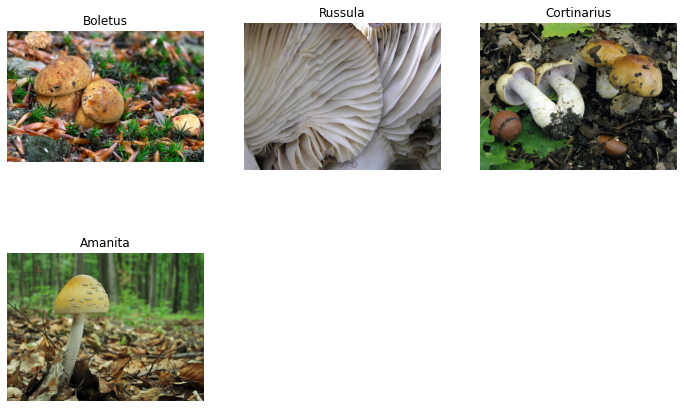

In [ ]:
# Displaying examples from each class
nrows = 3
ncols = 3

pos = 0
# test_path = './Dataset/val/'
# train_path = './Dataset/train/'

# test_path = './Dataset_4_classes/test/'
# train_path = './Dataset_4_classes/train/'

test_path = './Dataset_4c_avg/test/'
train_path = './Dataset_4c_avg/train/'

k = 0
for subfolder in os.listdir(test_path):
    
    k = k + 1
    image_file = os.listdir(os.path.join(test_path, subfolder))[0]
    
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)

    pos += 1
    sp = plt.subplot(nrows, ncols, pos)

    cur_image = mpimg.imread(os.path.join(test_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder)
    plt.axis('Off')

class_number = k
print(f"Class used: {class_number}")

In [ ]:
CLASSES = os.listdir('./Dataset_4c_avg/train/')
print(CLASSES)

from keras.utils import image_dataset_from_directory
from tensorflow.python import data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Create image datasets
train_data = image_dataset_from_directory(train_path, labels='inferred', 
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    subset='training', validation_split=0.2, seed=1234)

validation_data = image_dataset_from_directory(train_path, labels='inferred', 
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, 
    subset='validation', validation_split=0.2, seed=1234)

test_data = image_dataset_from_directory(test_path, labels='inferred', 
    image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)


test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory=test_path,
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

['Boletus', 'Russula', 'Cortinarius', 'Amanita']
Found 3424 files belonging to 4 classes.
Using 2740 files for training.
Found 3424 files belonging to 4 classes.
Using 684 files for validation.
Found 382 files belonging to 4 classes.
Found 382 images belonging to 4 classes.


Display an image example from each class.

In the next section we define some functions used to visualize the class distributions.

In [ ]:
def get_class_distribution(dataset, to_print=False):
  
  len([name for name in os.listdir(dataset) if os.path.isfile(os.path.join(dataset, name))])

  distribution = []
  total = 0
  classes = []
  for dir in tqdm(os.listdir(dataset)):
    sub_dir = dataset + "/" + dir + "/*"
    number = len(glob.glob(sub_dir)) #len(os.listdir(sub_dir))
    distribution.append(number)
    total += number
    classes.append(dir)
    
  if print:
    for i in range(NUM_CLASSES):
      print(f'Number of {classes[i]}: {distribution[i]}, proportion: {distribution[i]/(total)}')
  
  return distribution, total



def plot_class_distribution(dataset, name):
  distribution, _ = get_class_distribution(dataset, to_print=True)

  plt.figure(figsize=(10, 6), dpi=80)
  plt.bar(CLASSES, height=distribution)
  plt.title(f'Barplot of class distribution of {name} dataset')

from keras import layers

def get_data_augmentation():
  # augment the dataset to reduce overfitting
    data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    layers.RandomZoom(0.3),
    layers.RandomBrightness(0.6),
    layers.RandomTranslation(0.2, 0.2)
  ])
    return data_augmentation


  0%|          | 0/4 [00:00<?, ?it/s]

Number of Boletus: 965, proportion: 0.2818341121495327
Number of Russula: 1032, proportion: 0.3014018691588785
Number of Cortinarius: 752, proportion: 0.21962616822429906
Number of Amanita: 675, proportion: 0.1971378504672897


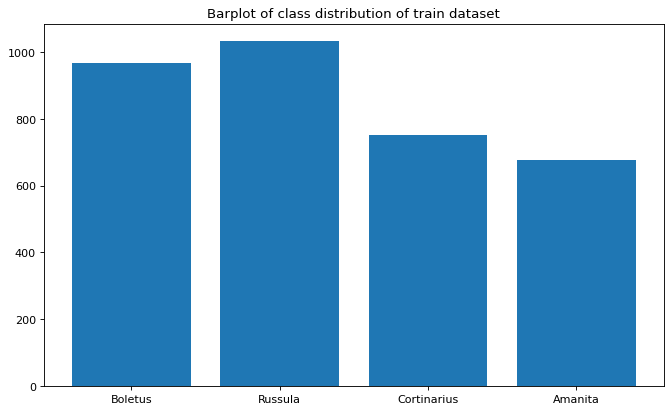

In [ ]:
TRAIN_DIR = './Dataset_4c_avg/train/'
plot_class_distribution(TRAIN_DIR, "train")

  0%|          | 0/4 [00:00<?, ?it/s]

Number of Boletus: 108, proportion: 0.28272251308900526
Number of Russula: 115, proportion: 0.3010471204188482
Number of Cortinarius: 84, proportion: 0.2198952879581152
Number of Amanita: 75, proportion: 0.19633507853403143


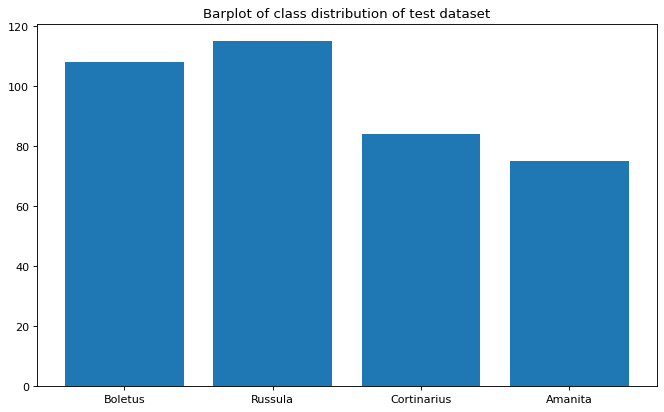

In [ ]:
TEST_DIR = './Dataset_4c_avg/test/'
plot_class_distribution(TEST_DIR, "test")

## CNN creation

In [ ]:
data_augmentation = get_data_augmentation()

In [ ]:
from keras import layers

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=12, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=1)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=384, kernel_size=3, padding="same", activation="relu")(x)
x = layers.GlobalMaxPooling2D()(x)
x = layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.7)(x)
outputs = layers.Dense(class_number, activation="softmax", name='classifier')(x)
cnn = keras.Model(inputs, outputs)

# Check the model
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 169, 169, 32)      13856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 168, 168, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 168, 168, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 168, 168, 256)     73984 

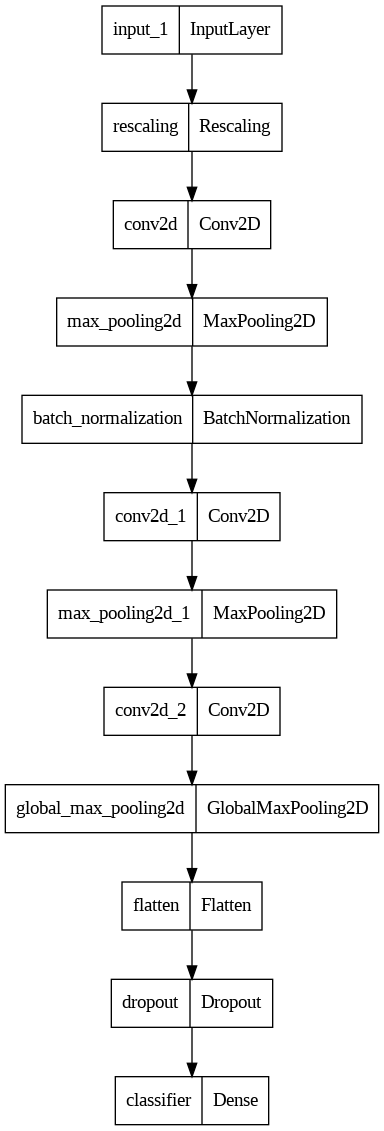

In [ ]:
tf.keras.utils.plot_model(cnn)

## Training the network

In [ ]:
# Callbacks
dir_name = "/content/drive/Shareddrives/Progetto_CIDL/Models"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
save_path = os.path.join(dir_name, f'CNN_from_scratch_{IMG_SIZE}.h5')

earlystopping = EarlyStopping(monitor='val_accuracy',
                              patience=10,
                              restore_best_weights=True,
                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=1e-8)
checkpoint_model_save = keras.callbacks.ModelCheckpoint(
                                        filepath=save_path,
                                        monitor="val_loss",
                                        verbose=1,
                                        save_best_only=True)

In [ ]:
import os
from keras import optimizers

cnn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

callbacks_list = [
    earlystopping,
    reduce_lr,
    checkpoint_model_save
]

history = cnn.fit(train_data, epochs=30, validation_data=validation_data, verbose=1, callbacks=callbacks_list)

Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 1.6404 - accuracy: 0.2956
Epoch 1: val_loss improved from inf to 1.36470, saving model to /content/drive/Shareddrives/Progetto_CIDL/Models/CNN_from_scratch_180.h5
43/43 [==============================] - 20s 162ms/step - loss: 1.6404 - accuracy: 0.2956 - val_loss: 1.3647 - val_accuracy: 0.3289 - lr: 0.0010
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 1.3289 - accuracy: 0.3803
Epoch 2: val_loss improved from 1.36470 to 1.35540, saving model to /content/drive/Shareddrives/Progetto_CIDL/Models/CNN_from_scratch_180.h5
43/43 [==============================] - 5s 106ms/step - loss: 1.3289 - accuracy: 0.3803 - val_loss: 1.3554 - val_accuracy: 0.3085 - lr: 0.0010
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 1.2923 - accuracy: 0.4080
Epoch 3: val_loss improved from 1.35540 to 1.31968, saving model to /content/drive/Shareddrives/Progetto_CIDL/Models/CNN_from_scratch_180.h5
43/43 [===

## Plot results data

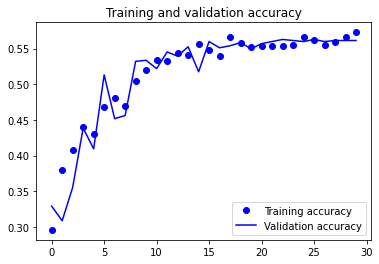

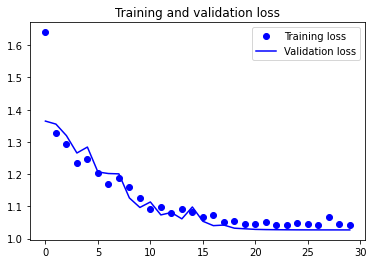

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Testing

In [ ]:
loss, accuracy = cnn.evaluate(test_data,
                                    steps=11, 
                                    verbose=2, 
                                    use_multiprocessing=True, 
                                    workers=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

11/11 - 1s - loss: 1.0016 - accuracy: 0.5419 - 1s/epoch - 93ms/step
Model performance on test images:
Accuracy = 0.5418848395347595
Loss = 1.001638650894165


<ipython-input-19-beb7811b6688>:30: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, nb_samples // BATCH_SIZE+1)


Confusion Matrix
[[27 16  6 26]
 [ 4 84  8 12]
 [ 2 28 21 33]
 [18 20  2 75]]
Classification Report
              precision    recall  f1-score   support

     Amanita       0.53      0.36      0.43        75
     Boletus       0.57      0.78      0.66       108
 Cortinarius       0.57      0.25      0.35        84
     Russula       0.51      0.65      0.57       115

    accuracy                           0.54       382
   macro avg       0.54      0.51      0.50       382
weighted avg       0.54      0.54      0.52       382



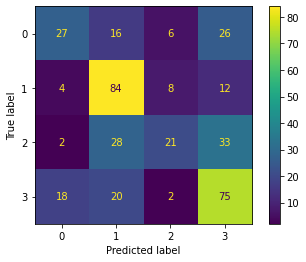

In [ ]:
from pandas.core.dtypes.common import classes
import numpy as np
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

nb_samples = 382 # number of test images
Y_pred = cnn.predict_generator(test_generator, nb_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)
# x is true class, y is predicted class-- middle diagonal represents the accurate predictions

print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()